# COSI 120A - Assignment 2

## User-user & Item-item

In [4]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
# load data
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('/Users/tmh/Desktop/massive data/hw2/ua_train', names=header)
df=df.iloc[1:,:-1]

df_test = pd.read_csv('/Users/tmh/Desktop/massive data/hw2/ua_test', names=header)
df_test=df_test.iloc[1:,:-1]


n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

n_users_test = df_test.user_id.unique().shape[0]
n_items_test = df_test.item_id.unique().shape[0]
print('Number of users = ' + str(n_users_test) + ' | Number of movies = ' + str(n_items_test))


Number of users = 943 | Number of movies = 1680
Number of users = 943 | Number of movies = 1129


In [6]:
# Build user-item matrix
train_data_matrix = np.zeros((n_users, 1682))
for line in df.itertuples():
    train_data_matrix[int(line[1]) - 1, int(line[2]) - 1] = int(line[3])

test_data_matrix = np.zeros((n_users_test, 1682))
for line in df_test.itertuples():
    test_data_matrix[int(line[1]) - 1, int(line[2]) - 1] = int(line[3])


In [11]:
# Caculate Pearson similarity
def pearson_sim(user1,user2):
    # Find common movies
    user1_data = train_data_matrix[user1]
    user2_data = train_data_matrix[user2]
    distance = 0
    common = {}

    for key in user1_data:
        if key in user2_data:
            common[key] = 1
    if len(common) == 0:
        return 0# If no common, return 0
    n = len(common)
    print(n,common)
    
    common_keys = []
    for movie in list(common.keys()):
        movie = int('{:g}'.format(movie))
        common_keys.append(movie)

    ## sum
    sum1 = sum([float(user1_data[m]) for m in common_keys])
    sum2 = sum([float(user2_data[m]) for m in common_keys])
 
    ## sum square
    sum1Sq = sum([pow(float(user1_data[m]),2) for m in common_keys])
    sum2Sq = sum([pow(float(user2_data[m]),2) for m in common_keys])
 
    ## dot sum
    PSum = sum([float(user1_data[i])*float(user2_data[i]) for i in common_keys])
 

    num = PSum - (sum1*sum2/n)
    den = sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den == 0:
        return 0
    r = num/den
    
    return r
  
R = pearson_sim(1,5)
print(R)

6 {4.0: 1, 0.0: 1, 2.0: 1, 3.0: 1, 5.0: 1, 1.0: 1}
1.0


I wrote Pearson similarity function but I don't know how to extend it to calculate pairwise similarity, therefore, I used the pairwise distance package from sklearn.

In [ ]:
# Caculate Pearson similarity, build pairwise distance matrix
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1-pairwise_distances(train_data_matrix, metric='correlation')
item_similarity = 1-pairwise_distances(train_data_matrix.T, metric='correlation')
item_similarity[np.isnan(item_similarity)] = 0.


### User-user CF with no bias:

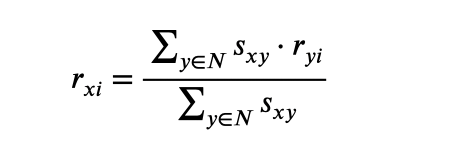

### Item-item CF with no bias:

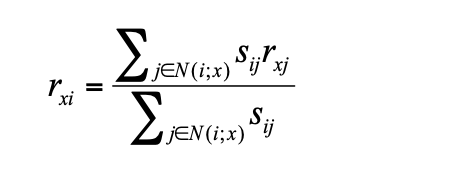

In [15]:
# Predict for user-user and item-item

def predict(ratings, similarity, type='user'):
    if type == 'user':
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


# Prediction result
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')
print(item_prediction)
print(user_prediction)



[[ 1.20575592e+00  1.05776077e+00  1.06092610e+00 ... -3.83524777e-01
   7.27923417e-01  1.03877190e+00]
 [ 1.64851256e-01  6.55151027e-02  1.38621512e-01 ...  1.53611983e-01
   5.76732147e-02 -3.08608904e-04]
 [ 1.55859076e-02  3.62473020e-02  6.32297976e-02 ...  2.85428995e-01
   4.65915557e-02 -1.21376955e-02]
 ...
 [ 8.23940204e-02  3.50281795e-02  5.93008473e-02 ... -3.02891516e-03
   1.65663641e-02  3.22126583e-02]
 [ 2.87890420e-01  2.53027729e-01  1.68561555e-01 ...  3.93835780e-02
   2.09133821e-01  8.43443987e-02]
 [ 7.67503176e-01  8.17670528e-01  7.14637947e-01 ... -2.91805358e-01
   5.58121359e-01  5.42889427e-01]]
[[ 2.27634382e+00  7.53103324e-01  4.50149522e-01 ... -3.24749601e-04
   7.33693979e-03  8.78082970e-03]
 [ 1.59825805e+00  2.29701285e-01  2.71835011e-01 ...  4.66561741e-03
   2.19309148e-03  3.74196106e-04]
 [ 7.74300785e-01  1.32818230e-01  1.63851774e-01 ...  1.13742286e-02
   1.82154659e-03 -9.00610701e-04]
 ...
 [ 2.28462801e+00  3.59512512e-01  3.6825426

In [16]:
# Evaluation, RMSE

from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))



User-based CF RMSE: 2.918780824203301
Item-based CF RMSE: 3.4153608073521657


## Item-item CF with bias:

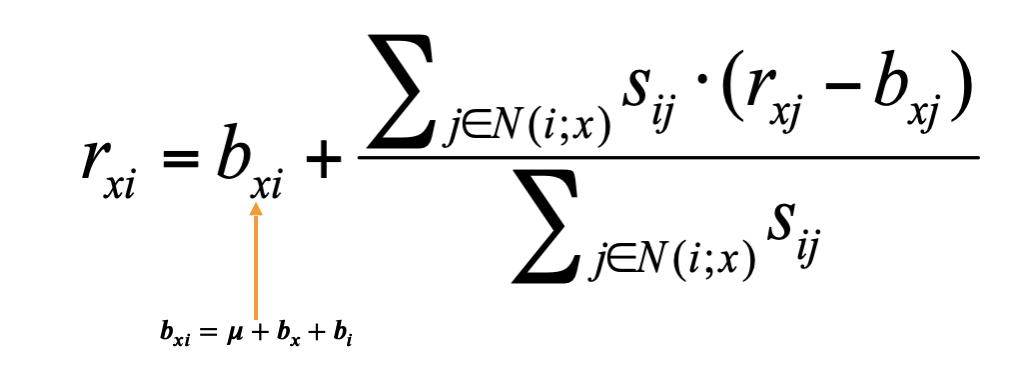

In [41]:

miu = sum(train_data_matrix.mean(axis=0))/len(train_data_matrix[0])
bx = train_data_matrix.mean(axis=1) - miu
bi = train_data_matrix.mean(axis=0) - miu
bxi = []
for i in range(len(train_data_matrix)):
    for j in range (len(train_data_matrix[0])):
        a = miu + bx[i] + bi[j]
        bxi.append(a)
        
bxi = np.mat(bxi).reshape(len(train_data_matrix),len(train_data_matrix[0]))
ratings2 = train_data_matrix - bxi
pred = bxi + ratings2.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
pred = pred.A

In [43]:
print('Item-based CF RMSE: ' + str(rmse(pred, test_data_matrix)))


Item-based CF RMSE: 3.0748013513907555


*RMSE with bias decrease!*

## LFM

In [10]:

K= 5  # number of latent factors 
max_iter = 1000 
alpha = 0.02 # learning rate
lamda = 0.04 # regulation coefficient


def LFM(R,K,max_iter,alpha=0.0002,lamda = 0.002):

    M = len(R)
    N = len(R[0])
    
    # Random generate initial P, Q
    P = np.random.rand(M,K)
    Q = np.random.rand(N,K)
    Q = Q.T
    
    # Iteration
    for step in range(max_iter):
        # Iterate all eigenvectors Pu and Qi
        for u in range(M):
            for i in range(N):
                # Caculate residual for ratings > 0 
                if R[u][i] > 0:
                    eui = np.dot(P[u,:],Q[:,i]) - R[u][i]
                    
                    # Update P Q
                    for k in range(K):
                        P[u][k] = P[u][k] - alpha * (2 * eui * Q[k][i] + 2 * lamda * P[u][k])
                        Q[k][i] = Q[k][i] - alpha * (2 * eui * P[u][k] + 2 * lamda * Q[k][i])
                        
        # Finish u,i iteration, all eigenvectors updated, get P, Q, caculate rating matrix
        predR = np.dot(P,Q)
        
        #Caculate loss function
        cost = 0
        for u in range(M):
            for i in range(N):
                if R[u][i] > 0:
                    cost += (np.dot(P[u,:],Q[:,i]) - R[u][i]) ** 2
                    # Add regulation coefficient
                    for k in range(K):
                        cost += lamda * (P[u][k] ** 2 + Q[k][i] ** 2)
                        
        if cost < 0.01:
            break
    
    return P,Q.T,cost
P,Q,cost = LFM(train_data_matrix,K,max_iter,alpha,lamda)


predR = P.dot(Q.T)
predR


array([[3.07594902, 2.99223103, 2.22665337, ..., 1.26583956, 3.84768174,
        2.71434115],
       [3.36864412, 3.16382934, 2.63281079, ..., 1.43570755, 3.4904    ,
        2.98440198],
       [3.04307719, 3.23099822, 3.01754475, ..., 1.40859636, 3.70765505,
        2.46678075],
       ...,
       [4.20803608, 3.71538857, 2.4301302 , ..., 1.87831908, 3.45460268,
        2.47150393],
       [3.9501287 , 3.97425304, 2.82445373, ..., 1.28690395, 3.53353825,
        3.04788876],
       [3.56822259, 3.61562985, 3.69361795, ..., 1.89686711, 3.49221591,
        2.41476748]])

In [12]:
# Evaluation, RMSE
print('User-based LFM RMSE: ' + str(rmse(predR, test_data_matrix)))

User-based LFM RMSE: 1.1063240964008358


From the above low RMSE we can see LFM performs good, better than CF.